<a href="https://colab.research.google.com/github/unica-isde/isde-mnist/blob/main/notebooks/NMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load MNIST Handwritten Digit data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_mnist_data(filename):
    data = pd.read_csv(filename)
    data = np.array(data)
    y = data[:,0]
    x = data[:,1:] / 255
    return x, y


filename= 'sample_data/mnist_train_small.csv'
x, y = load_mnist_data(filename)

print(y.shape, x.shape)
print(y, np.max(x))


(19999,) (19999, 784)
[5 7 9 ... 2 9 5] 1.0


In [2]:
# count how many images we have for each class

class_labels = np.unique(y)
print(class_labels.size, class_labels.shape[0])
num_classes = class_labels.size

counts = np.zeros(shape=(10,), dtype=int)
for label in y:
    counts[label] += 1

for k in range(num_classes):
    counts[k] = (y==k).sum()
    print(k, counts[k])
print(counts.sum())




10 10
0 1962
1 2243
2 1989
3 2021
4 1924
5 1761
6 2038
7 2126
8 1912
9 2023
19999


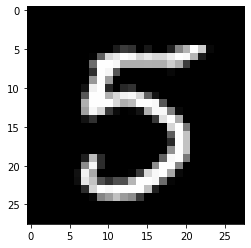

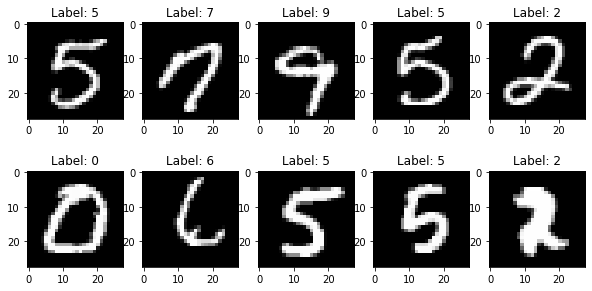

In [3]:
# plotting utils

image = x[0,:]

def plot_digit(image, shape=(28,28)):
    plt.imshow(np.reshape(image, newshape=shape), cmap='gray')


plot_digit(image)


def plot_ten_digits(x,y=None):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plot_digit(x[i,:])
        if y is not None:
            plt.title('Label: ' + str(y[i]))

plot_ten_digits(x,y)




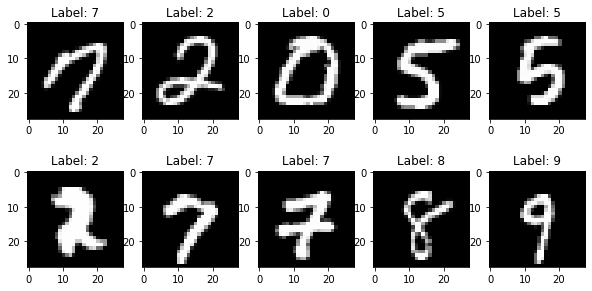

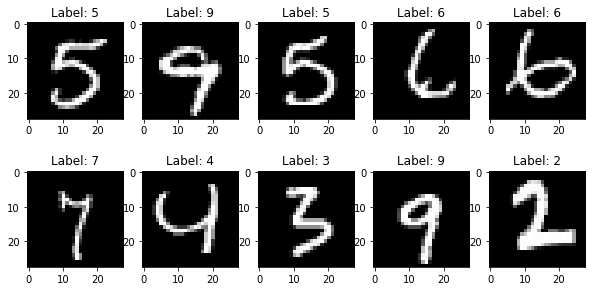

In [4]:
def split_data(x, y, tr_fraction=0.5):
    num_samples = y.size
    num_tr = int(tr_fraction * num_samples)
    num_ts = num_samples - num_tr
    tr_idx = np.zeros(shape=(num_samples,))
    tr_idx[0:num_tr] = 1

    np.random.shuffle(tr_idx)
    ytr = y[tr_idx==1]
    xtr = x[tr_idx==1, :]

    yts = y[tr_idx==0]
    xts = x[tr_idx==0, :]

    return xtr, ytr, xts, yts

xtr, ytr, xts, yts = split_data(x, y)

plot_ten_digits(xtr, ytr)
plot_ten_digits(xts, yts)


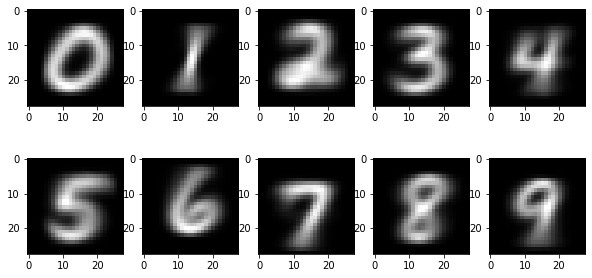

In [5]:
def fit(xtr, ytr):
    num_classes = np.unique(ytr).size
    num_features = xtr.shape[1]
    centroids = np.zeros(shape=(num_classes, num_features))

    for k in range(num_classes):
        xk = xtr[ytr==k, :]
        centroids[k, :] = np.mean(xk, axis=0)
    
    return centroids


centroids = fit(xtr, ytr)
plot_ten_digits(centroids)


In [28]:
# compute distance matrix between xts and centroids
from sklearn.metrics import pairwise_distances
import time

print(xts.shape, centroids.shape)

num_ts_samples = xts.shape[0]
num_centroids = centroids.shape[0]

dist = np.zeros(shape=(num_ts_samples, num_centroids))
dist1 = np.zeros(shape=(num_ts_samples, num_centroids))

t0 = time.time()
for i in range(num_ts_samples):
    for j in range(num_centroids):
        dist[i,j] = np.linalg.norm(xts[i, :]-centroids[j, :], ord=2)

t1 = time.time()
print("Elapsed time in msec:", t1-t0)

t0 = time.time()
for j in range(num_centroids):
    dist1[:,j] = np.linalg.norm(xts-centroids[j, :], ord=2, axis=1)
t1 = time.time()
print("Elapsed time in msec:", t1-t0)

print((dist-dist1 > 1e-12).sum())

t0 = time.time()
dist2 = pairwise_distances(xts, centroids)
t1 = time.time()
print("Elapsed time in msec:", t1-t0)

print((dist-dist2 > 1e-12).sum())

y_pred = np.argmin(dist, axis=1)
print(y_pred)
print(yts)

def predict(xts, centroids):
    dist = pairwise_distances(xts, centroids)
    y_pred = np.argmin(dist, axis=1)
    return y_pred

y_pred = predict(xts, centroids)

# measure test error
def test_error(y_pred, yts):
    return (y_pred != yts).mean()

print(test_error(y_pred, yts))

(10000, 784) (10, 784)
Elapsed time in msec: 0.8058795928955078
Elapsed time in msec: 0.3156857490539551
0
Elapsed time in msec: 0.03757834434509277
0
[5 9 5 ... 9 0 9]
[5 9 5 ... 5 0 9]
0.1877


In [39]:
# implement the full pipeline. Input: X, y --> Output: mean_test_error, std_dev
x, y = load_mnist_data(filename)

n_rep = 10
ts_error = np.zeros(shape=(n_rep,))

for rep in range(n_rep):
    xtr, ytr, xts, yts = split_data(x, y)
    centroids = fit(xtr, ytr)
    y_pred = predict(xts, centroids)
    ts_error[rep] = test_error(y_pred, yts)

print(ts_error.mean(), 2*ts_error.std())


0.19458999999999999 0.006179611638282774
